In this lab you will do the following steps in order:

1. Load a new dataset using ``torchvision dataloader``
2. Perform transfer learning of a pre-trained NN (Neural Network)





Useful resources:

* [dataloader](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class)
*   [network layers](https://pytorch.org/docs/stable/nn.html#convolution-layers)
*   [activation function](https://pytorch.org/docs/stable/nn.html#convolution-layers)
*   [loss functions](https://pytorch.org/docs/stable/nn.html#convolution-layers)






Use GPU if available

In [1]:
import torch
import glob  # Import library for finding all files matching a pattern
from PIL import Image  # Import library for image processing
import numpy as np  # Import library for numerical operations (not used here)
import os  # Import library for operating system functionalities
from tqdm import tqdm  # Import library for displaying progress bar

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

Data preparation

In [ ]:
# #download images
# !wget https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_crop.tar
# #download metadata
# !wget https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_meta.tar
# #extract
# !tar -xf imdb_crop.tar
# !tar -xf imdb_meta.tar

In [ ]:
# # move to data folder
# !mv imdb/ data/
# !mv imdb_crop/ data/

Remove grayscale images

In [ ]:
# # Define a path pattern to search for all jpg images within subdirectories of "data/imdb_crop"
# image_path_pattern = "data/imdb_crop/*/*.jpg"

# # Find all image file paths matching the pattern
# image_paths = glob.glob(image_path_pattern)

# imgs_removed = 0
# # Iterate through each image path
# for image_path in tqdm(image_paths):
#   # Open the image using Pillow's Image class
#   image = Image.open(image_path)

#   # Get the number of color channels in the image (e.g., RGB has 3 channels)
#   num_channels = len(image.getbands())

#   # Check if the image has a different number of channels than expected (likely grayscale or unsupported format)
#   if num_channels != 3:
#     # If not 3 channels, remove the image file
#     os.remove(image_path)
#     # print(f"Removed {image_path} (not RGB format)")  # Print statement to show removed files
#     imgs_removed += 1

# print(f"Removed {imgs_removed} images") ### --> Removed 22532 images

Define function to convert numeric date to common date format

In [ ]:
from datetime import datetime, timedelta  # Import libraries for date and time manipulation

def datenum_to_datetime(datenum):
  """
  Converts a date represented as a floating-point number (Excel-style) to a Python datetime object.

  Args:
      datenum (float): The date represented as a floating-point number.

  Returns:
      datetime: The converted datetime object (year only if conversion fails).
          If conversion fails due to ValueError, TypeError, or OverflowError,
          returns np.nan.
  """

  try:
    # Extract components from the datenum
    days = datenum % 1  # Extract days (decimal part)
    hours = days % 1 * 24  # Extract hours from remaining decimal part
    minutes = hours % 1 * 60  # Extract minutes from remaining decimal part
    seconds = minutes % 1 * 60  # Extract seconds from remaining decimal part

    # Convert to datetime object with separate day, hour, minute, and second components
    exact_date = (datetime.fromordinal(int(datenum))  # Convert integer part to date
                 + timedelta(days=int(days))  # Add extracted days
                 + timedelta(hours=int(hours))  # Add extracted hours
                 + timedelta(minutes=int(minutes))  # Add extracted minutes
                 + timedelta(seconds=round(seconds)))  # Add extracted seconds (rounded)

    # Adjust for Excel's epoch being different from standard epoch (correct for year)
    exact_date -= timedelta(days=366)

    # Return the year from the converted datetime object
    return exact_date.year

  except (ValueError, TypeError, OverflowError) as e:
    return np.nan  # Return np.nan if conversion fails


Define the [dataloader](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class) class

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import pandas as pd
import scipy
import torch
import collections

class FacesDataset(Dataset):
      """Face Landmarks dataset.

      This class loads and preprocesses a dataset of face images with corresponding ages.
      It supports train, validation, and test splits.
      """

      def __init__(self, root_dir, transform, split):
        """
        Args:
            root_dir (string): Directory containing the images.
            transform (callable, optional): Transformation to be applied to the images.
            split (string): Split type ("train", "val", or "test").
        """
        self.split=split
        self.root_dir = root_dir
        self.data = self.get_data()  # Load and preprocess data
        total_data_len = int(len(self.data) * 0.5)  # Select small portion of the dataset

        # Randomly shuffle indices for train/val/test split
        idx = np.arange(total_data_len)
        np.random.seed(0)
        np.random.shuffle(idx)
        print(f"Shuffled indices (first 5): {idx[:5]}")  # Print first 5 shuffled indices

        # Select data based on split
        if split == "train":
            self.data = self.data[idx[:int(total_data_len * 0.6)]]
            print(split, ' indexes ', idx[:int(total_data_len * 0.6)])
        elif split == "val":
            self.data = self.data[idx[int(total_data_len * 0.6):int(total_data_len * 0.8)]]
            print(split, ' indexes ', idx[int(total_data_len * 0.6):int(total_data_len * 0.8)])
        else:
            self.data = self.data[idx[int(total_data_len * 0.8):]]
            print(split, ' indexes ', idx[int(total_data_len * 0.8):])

        # Analyze age distribution (uncomment to print)
        # age_distribution = collections.Counter()
        # for i, sample in enumerate(self.data):
        #     age_distribution[sample[1]] += 1
        # print(age_distribution)  # Uncomment to print the Counter object


        self.transform = transform



      def get_data(self):
        """
        Loads and preprocesses data from the IMDB dataset (.MAT file).

        This function performs the following steps:
            1. Loads data from the MAT file using scipy.io.loadmat.
            2. Defines column names for the loaded data.
            3. Converts the loaded data into a dictionary.
            4. Creates a pandas DataFrame for efficient data manipulation.
            5. Prints DataFrame shape and the first few rows (before processing).
            6. Converts date of birth to age using vectorized operations.
            7. Filters images based on face score and presence of a single face.
                - Removes images without a face (face_score != -np.inf).
                - Ensures only one face is present (second_face_score.isna()).
                - Filters based on minimum face score threshold (face_score >= 3.5).
                - Filters for valid age range (0 <= age <= 100).
                - Converts age to integer and drops unnecessary columns.
            8. Constructs full image paths by prepending the root directory.
            9. Filters for images with existing paths using vectorized boolean indexing.
            10. Prints DataFrame shape and the first few rows (after processing).
            11. Returns the preprocessed data as a NumPy array.
        """

        # Load data from MAT file and define column names
        mat_imdb = scipy.io.loadmat('data/imdb/imdb.mat')
        columns = ["full_path", "dob", "photo_taken", "second_face_score", "face_score"]

        # Convert loaded data into a dictionary
        data_dict = {col: mat_imdb['imdb'][0][0][col][0] for col in columns}

        # Create pandas DataFrame for efficient data manipulation
        df_imdb = pd.DataFrame(data_dict)
        if self.split=="train":
          print("Before processing:")
          print(df_imdb.shape)  # Print DataFrame shape
          print(df_imdb.head())  # Print the first few rows 

        # Convert date of birth to age using vectorized operations
        df_imdb['date_of_birth'] = df_imdb['dob'].apply(datenum_to_datetime)
        df_imdb['age'] = df_imdb['photo_taken'].sub(df_imdb['date_of_birth'])  # Handle potential NaNs

        # Filter images based on face score and presence of a single face
        df_imdb = df_imdb[df_imdb['face_score'] != -np.inf]  # Remove images without a face
        df_imdb = df_imdb[df_imdb['second_face_score'].isna()]  # Ensure only one face is present
        df_imdb = df_imdb[df_imdb['face_score'] >= 3.5]  # Filter based on minimum face score threshold
        df_imdb = df_imdb[(df_imdb['age'] <= 100) & (df_imdb['age'] >= 0)]  # Filter for valid age range
        df_imdb['age'] = df_imdb['age'].apply(lambda x: int(x))  # Convert age to integer
        df_imdb = df_imdb.drop(columns=['date_of_birth', 'dob', 'photo_taken', "second_face_score", "face_score"])  # Remove unnecessary columns

        print(self.root_dir)
        # Construct full image paths using vectorized operations
        df_imdb['full_path'] = self.root_dir+"/"+ df_imdb['full_path'].apply(lambda x: x[0])

        # Filter for images with existing paths using vectorized boolean indexing
        df_imdb = df_imdb[df_imdb['full_path'].apply(os.path.exists)]

        if self.split=="train":
          print("After processing:")
          print(df_imdb.shape)  # Print DataFrame shape
          print(df_imdb.head())  # Print the first few rows

        return df_imdb.to_numpy()  # Return preprocessed data as a NumPy array

      def __len__(self):
        """
        Returns the length of the dataset (number of samples).

        This method overrides the default behavior of `len` for the dataset object.
        It simply returns the length of the internal `data` list, which represents
        the preprocessed data after loading and filtering.
        """
        return len(self.data)

      def __getitem__(self, idx):
        """
        Retrieves a sample (image and corresponding age) at a given index.

        This method overrides the default behavior of indexing for the dataset object.
        It takes an index `idx` and performs the following:
            1. Accesses the image name and age at the specified index from `self.data`.
            2. Opens the image using `Image.open` with the full path constructed by
               combining `self.root_dir` and `img_name`.
            3. Applies the defined transformation (`self.transform`) to the image.
            4. Normalizes the age by dividing by 100.
            5. Creates a dictionary `sample` containing the preprocessed image (`image`)
               and the normalized age as a PyTorch tensor (`torch.tensor(age).float()`).
            6. Returns the constructed `sample` dictionary.
        """
        img_name, age = self.data[idx]
        # image = Image.open(os.path.join(self.root_dir, img_name))
        image = Image.open(os.path.join(img_name))
        image = self.transform(image)
        age = age / 100

        sample = {'image': image, 'age': torch.tensor(age).float()}
        return sample

Build the train/val/test dataloaders




In [ ]:
import pickle

# Define data transformations (augmentations for training and normalization)
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally for training augmentation
    transforms.ToTensor(),  # Convert PIL images to PyTorch tensors
    transforms.Normalize(  # Normalize pixel values based on ImageNet statistics
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

transform_val = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256 (consistent with training)
    transforms.ToTensor(),  # Convert PIL images to PyTorch tensors
    transforms.Normalize(  # Normalize pixel values using the same statistics
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Set batch size
bs = 128

# Create datasets for training, validation, and testing
print("Train set:")
trainset = FacesDataset("data/imdb_crop", transform_train, split="train")
print("Validation set:")
valset = FacesDataset("data/imdb_crop", transform_val, split="val")
print("Test set:")
testset = FacesDataset("data/imdb_crop", transform_val, split="test")

# Create data loaders for efficient batch training and evaluation
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=1, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)

# Print dataset and dataloader lengths (number of samples and batches)
print(f"Number of training samples: {len(trainloader) * bs}")
print(f"Number of validation samples: {len(valloader)}")
print(f"Number of test samples: {len(testloader)}")


Train set:
Before processing:
(460723, 5)
                                        full_path     dob  photo_taken  \
0   [01/nm0000001_rm124825600_1899-5-10_1968.jpg]  693726         1968   
1  [01/nm0000001_rm3343756032_1899-5-10_1970.jpg]  693726         1970   
2   [01/nm0000001_rm577153792_1899-5-10_1968.jpg]  693726         1968   
3   [01/nm0000001_rm946909184_1899-5-10_1968.jpg]  693726         1968   
4   [01/nm0000001_rm980463616_1899-5-10_1968.jpg]  693726         1968   

   second_face_score  face_score  
0           1.118973    1.459693  
1           1.852008    2.543198  
2           2.985660    3.455579  
3                NaN    1.872117  
4                NaN    1.158766  
data/imdb_crop
After processing:
(71828, 2)
                                            full_path  age
7   data/imdb_crop/02/nm0000002_rm1363385088_1924-...   80
15  data/imdb_crop/02/nm0000002_rm2585828096_1924-...   82
18  data/imdb_crop/02/nm0000002_rm2769394176_1924-...   82
19  data/imdb_crop/02/n

In [ ]:
!pwd
!ls
!ls data/
!ls data/imdb/

/home/andrea/unimib/Supervised/00_exercises/lab_06


data	       imdb_meta.tar			       models
imdb_crop.tar  lab_06_CNN_transfer_learning_all.ipynb  output
imdb  imdb_crop
imdb.mat


2. Define a Neural Network (NN) [Mobilenet](https://pytorch.org/vision/main/models/generated/torchvision.models.mobilenet_v2.html#torchvision.models.mobilenet_v2) pretrained on Imagenet.

Replace the last classifier

In [ ]:
import torchvision
import torch.nn as nn

# Define the model architecture (MobileNetV2)
net = torchvision.models.resnet18(weights='IMAGENET1K_V1')  # Load pre-trained weights
net_name = net.__class__.__name__ + '18' # Get the name of the network class
print(net_name)

print(net)

# MObileNetV2
# # Adjust the final classification layer
# num_ftrs = net.classifier[1].in_features  # Get the number of input features for the last layer
# net.classifier = nn.Sequential(
#     nn.Linear(num_ftrs, 512),  # First linear layer with 512 units
#     nn.GELU(),  # GELU activation function
#     nn.Linear(512, 32),  # Second linear layer with 32 units
#     nn.GELU(),  # GELU activation function
#     nn.Linear(32, 1)   # Output layer with 1 unit (for age prediction)
# )

# ResNet18
# Adjust the final classification layer
num_ftrs = net.fc.in_features  # Get the number of input features for the last layer
print(num_ftrs)
net.fc = nn.Sequential(
    # nn.Linear(num_ftrs, 512),  # First linear layer with 512 units
    # nn.GELU(),  # GELU activation function
    nn.Linear(512, 32),  # Second linear layer with 32 units
    nn.GELU(),  # GELU activation function
    nn.Linear(32, 1)   # Output layer with 1 unit (for age prediction)
)

# Move the model to the appropriate device (CPU or GPU)
net.to(device)

ResNet18
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
from torchsummary import summary
# Print model summary
summary(net, (3, 256, 256))  # Input shape (channels, height, width)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

**Transfer learning**

Train only the last layers

In [ ]:
# Freeze pre-trained layers and unfreeze the classifier for fine-tuning
for key, value in dict(net.named_children()).items():
    if 'fc' in key or 'layer3' in key or 'layer4' in key:
        for param in value.parameters():
            param.requires_grad = True
            print(f"Unfreezing layer: {key}, Parameter shape: {param.shape}")  # Print unfrozen layers (classifier)
    else:
        for param in value.parameters():
            param.requires_grad = False
            # print(f"Unfreezing layer: {key}, Parameter shape: {param.shape}")  # Print unfrozen layers (classifier)

Unfreezing layer: layer4, Parameter shape: torch.Size([512, 256, 3, 3])
Unfreezing layer: layer4, Parameter shape: torch.Size([512])
Unfreezing layer: layer4, Parameter shape: torch.Size([512])
Unfreezing layer: layer4, Parameter shape: torch.Size([512, 512, 3, 3])
Unfreezing layer: layer4, Parameter shape: torch.Size([512])
Unfreezing layer: layer4, Parameter shape: torch.Size([512])
Unfreezing layer: layer4, Parameter shape: torch.Size([512, 256, 1, 1])
Unfreezing layer: layer4, Parameter shape: torch.Size([512])
Unfreezing layer: layer4, Parameter shape: torch.Size([512])
Unfreezing layer: layer4, Parameter shape: torch.Size([512, 512, 3, 3])
Unfreezing layer: layer4, Parameter shape: torch.Size([512])
Unfreezing layer: layer4, Parameter shape: torch.Size([512])
Unfreezing layer: layer4, Parameter shape: torch.Size([512, 512, 3, 3])
Unfreezing layer: layer4, Parameter shape: torch.Size([512])
Unfreezing layer: layer4, Parameter shape: torch.Size([512])
Unfreezing layer: fc, Paramete

Define a loss function and optimizer

Let's use a Regression [L1Loss](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html) loss and [ADAM](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam) optimizer. [learning rate scheduler](https://towardsdatascience.com/a-visual-guide-to-learning-rate-schedulers-in-pytorch-24bbb262c863#fad1)



In [ ]:
import torch.optim as optim  # Optimization algorithms for training the model
import torch.nn.functional as F  # Common loss functions and activation functions
from scipy.stats import spearmanr, pearsonr  # Statistical functions for correlation calculation
import itertools  # Utility functions for generating combinations
from torch.optim.lr_scheduler import CosineAnnealingLR  # Learning rate scheduler for training
import matplotlib.pyplot as plt  # Plotting library for visualization


# Define training parameters (epochs, loss function, optimizer, and scheduler)
epochs = 10  # Number of training epochs
criterion = nn.L1Loss()  # L1 loss function for regression (mean absolute error)
optimizer = optim.Adam(net.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001
scheduler = CosineAnnealingLR(optimizer,
                              T_max=len(trainloader) * epochs,  # Maximum number of iterations for scheduler
                              eta_min=1e-5)  # Minimum learning rate for scheduler


**Fine-tuning**

Train the network on the training data performing a validation at the end of each epoch. The evaluation is done using [PLCC](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) and [SROCC](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient)

1, [33, 337] loss: 0.1276	PLCC: 0.212	SROCC: 0.325	lr: 0.001000
1, [66, 337] loss: 0.0751	PLCC: 0.654	SROCC: 0.596	lr: 0.000999
1, [99, 337] loss: 0.0752	PLCC: 0.682	SROCC: 0.644	lr: 0.000998
1, [132, 337] loss: 0.0720	PLCC: 0.690	SROCC: 0.649	lr: 0.000996
1, [165, 337] loss: 0.0706	PLCC: 0.714	SROCC: 0.690	lr: 0.000994
1, [198, 337] loss: 0.0697	PLCC: 0.722	SROCC: 0.692	lr: 0.000992
1, [231, 337] loss: 0.0682	PLCC: 0.725	SROCC: 0.709	lr: 0.000989
1, [264, 337] loss: 0.0681	PLCC: 0.746	SROCC: 0.712	lr: 0.000985
1, [297, 337] loss: 0.0686	PLCC: 0.732	SROCC: 0.701	lr: 0.000981
1, [330, 337] loss: 0.0719	PLCC: 0.717	SROCC: 0.686	lr: 0.000977
Validation loss: 0.068934	PLCC: 0.763	SROCC: 0.732


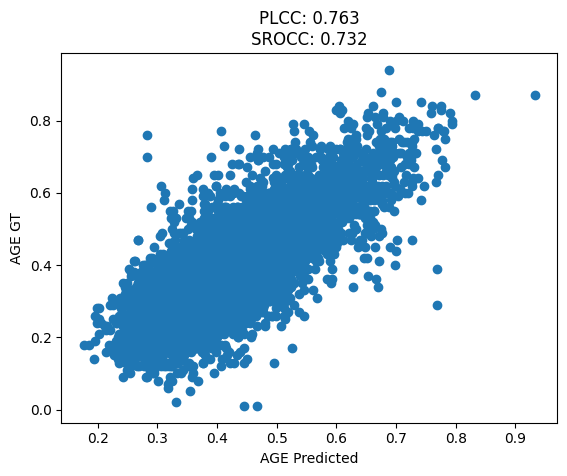

2, [33, 337] loss: 0.0656	PLCC: 0.762	SROCC: 0.743	lr: 0.000971
2, [66, 337] loss: 0.0601	PLCC: 0.789	SROCC: 0.760	lr: 0.000965
2, [99, 337] loss: 0.0637	PLCC: 0.776	SROCC: 0.754	lr: 0.000960
2, [132, 337] loss: 0.0647	PLCC: 0.753	SROCC: 0.731	lr: 0.000953
2, [165, 337] loss: 0.0634	PLCC: 0.779	SROCC: 0.747	lr: 0.000947
2, [198, 337] loss: 0.0649	PLCC: 0.779	SROCC: 0.754	lr: 0.000940
2, [231, 337] loss: 0.0605	PLCC: 0.791	SROCC: 0.762	lr: 0.000932
2, [264, 337] loss: 0.0587	PLCC: 0.785	SROCC: 0.768	lr: 0.000924
2, [297, 337] loss: 0.0605	PLCC: 0.786	SROCC: 0.758	lr: 0.000916
2, [330, 337] loss: 0.0592	PLCC: 0.804	SROCC: 0.778	lr: 0.000907
Validation loss: 0.058054	PLCC: 0.797	SROCC: 0.767


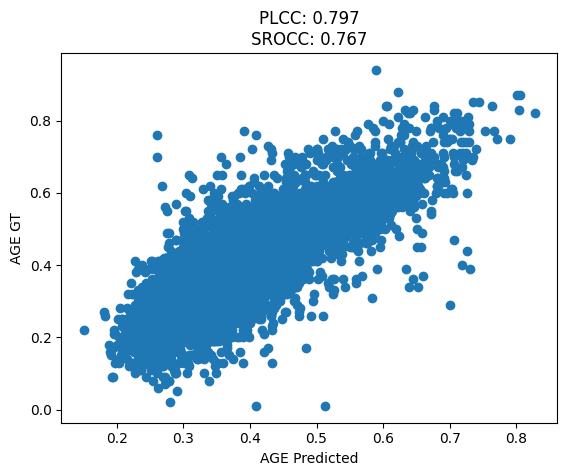

3, [33, 337] loss: 0.0574	PLCC: 0.810	SROCC: 0.791	lr: 0.000896
3, [66, 337] loss: 0.0587	PLCC: 0.812	SROCC: 0.790	lr: 0.000887
3, [99, 337] loss: 0.0575	PLCC: 0.819	SROCC: 0.798	lr: 0.000877
3, [132, 337] loss: 0.0565	PLCC: 0.800	SROCC: 0.773	lr: 0.000867
3, [165, 337] loss: 0.0554	PLCC: 0.835	SROCC: 0.808	lr: 0.000856
3, [198, 337] loss: 0.0571	PLCC: 0.808	SROCC: 0.787	lr: 0.000845
3, [231, 337] loss: 0.0578	PLCC: 0.804	SROCC: 0.781	lr: 0.000834
3, [264, 337] loss: 0.0556	PLCC: 0.816	SROCC: 0.799	lr: 0.000823
3, [297, 337] loss: 0.0561	PLCC: 0.818	SROCC: 0.798	lr: 0.000811
3, [330, 337] loss: 0.0568	PLCC: 0.813	SROCC: 0.804	lr: 0.000799
Validation loss: 0.063143	PLCC: 0.797	SROCC: 0.765


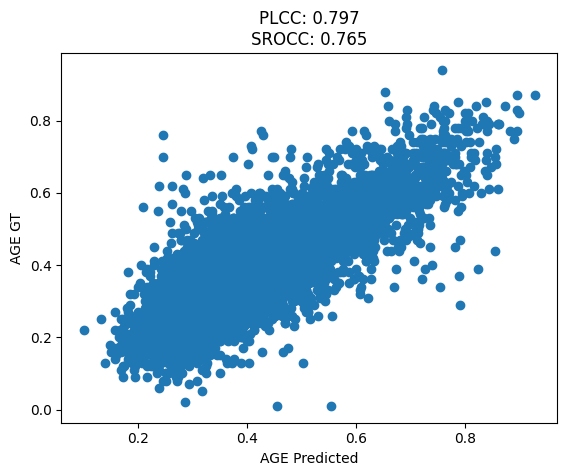

4, [33, 337] loss: 0.0553	PLCC: 0.817	SROCC: 0.802	lr: 0.000783
4, [66, 337] loss: 0.0512	PLCC: 0.853	SROCC: 0.830	lr: 0.000771
4, [99, 337] loss: 0.0519	PLCC: 0.838	SROCC: 0.810	lr: 0.000758
4, [132, 337] loss: 0.0532	PLCC: 0.840	SROCC: 0.825	lr: 0.000745
4, [165, 337] loss: 0.0529	PLCC: 0.835	SROCC: 0.818	lr: 0.000731
4, [198, 337] loss: 0.0532	PLCC: 0.829	SROCC: 0.819	lr: 0.000718
4, [231, 337] loss: 0.0556	PLCC: 0.827	SROCC: 0.815	lr: 0.000704
4, [264, 337] loss: 0.0543	PLCC: 0.839	SROCC: 0.813	lr: 0.000690
4, [297, 337] loss: 0.0519	PLCC: 0.837	SROCC: 0.815	lr: 0.000675
4, [330, 337] loss: 0.0515	PLCC: 0.854	SROCC: 0.830	lr: 0.000661
Validation loss: 0.056606	PLCC: 0.807	SROCC: 0.777


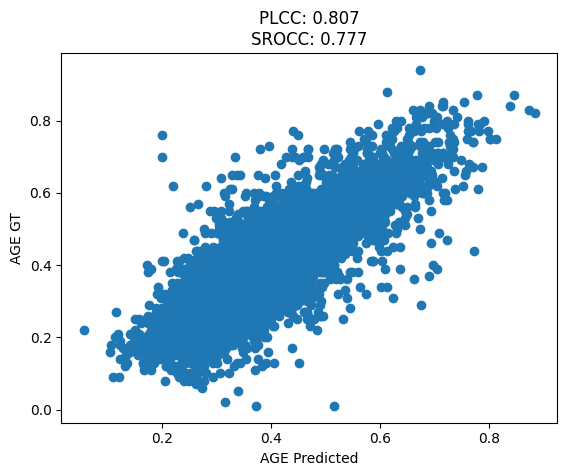

5, [33, 337] loss: 0.0504	PLCC: 0.856	SROCC: 0.847	lr: 0.000643
5, [66, 337] loss: 0.0483	PLCC: 0.857	SROCC: 0.857	lr: 0.000629
5, [99, 337] loss: 0.0496	PLCC: 0.849	SROCC: 0.829	lr: 0.000614
5, [132, 337] loss: 0.0487	PLCC: 0.862	SROCC: 0.849	lr: 0.000599
5, [165, 337] loss: 0.0482	PLCC: 0.869	SROCC: 0.852	lr: 0.000584
5, [198, 337] loss: 0.0501	PLCC: 0.854	SROCC: 0.825	lr: 0.000569
5, [231, 337] loss: 0.0515	PLCC: 0.852	SROCC: 0.831	lr: 0.000554
5, [264, 337] loss: 0.0496	PLCC: 0.852	SROCC: 0.828	lr: 0.000539
5, [297, 337] loss: 0.0471	PLCC: 0.874	SROCC: 0.860	lr: 0.000523
5, [330, 337] loss: 0.0462	PLCC: 0.875	SROCC: 0.863	lr: 0.000508
Validation loss: 0.056542	PLCC: 0.814	SROCC: 0.783


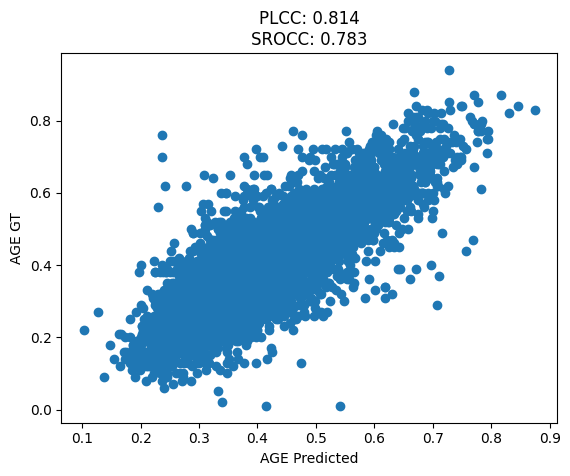

6, [33, 337] loss: 0.0449	PLCC: 0.885	SROCC: 0.869	lr: 0.000490
6, [66, 337] loss: 0.0441	PLCC: 0.885	SROCC: 0.872	lr: 0.000475
6, [99, 337] loss: 0.0473	PLCC: 0.862	SROCC: 0.852	lr: 0.000459
6, [132, 337] loss: 0.0435	PLCC: 0.890	SROCC: 0.874	lr: 0.000444
6, [165, 337] loss: 0.0431	PLCC: 0.889	SROCC: 0.880	lr: 0.000429
6, [198, 337] loss: 0.0462	PLCC: 0.877	SROCC: 0.867	lr: 0.000414
6, [231, 337] loss: 0.0455	PLCC: 0.878	SROCC: 0.868	lr: 0.000399
6, [264, 337] loss: 0.0435	PLCC: 0.888	SROCC: 0.874	lr: 0.000384
6, [297, 337] loss: 0.0440	PLCC: 0.890	SROCC: 0.878	lr: 0.000370
6, [330, 337] loss: 0.0446	PLCC: 0.886	SROCC: 0.876	lr: 0.000355
Validation loss: 0.054340	PLCC: 0.822	SROCC: 0.793


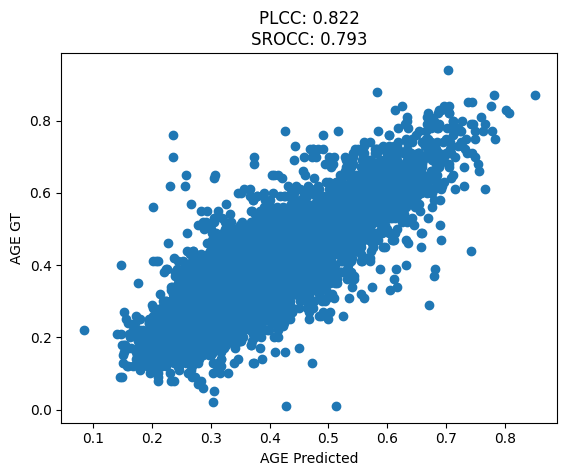

7, [33, 337] loss: 0.0385	PLCC: 0.912	SROCC: 0.905	lr: 0.000338
7, [66, 337] loss: 0.0392	PLCC: 0.907	SROCC: 0.895	lr: 0.000323
7, [99, 337] loss: 0.0414	PLCC: 0.903	SROCC: 0.899	lr: 0.000309
7, [132, 337] loss: 0.0403	PLCC: 0.901	SROCC: 0.886	lr: 0.000295
7, [165, 337] loss: 0.0392	PLCC: 0.907	SROCC: 0.894	lr: 0.000282
7, [198, 337] loss: 0.0391	PLCC: 0.906	SROCC: 0.899	lr: 0.000268
7, [231, 337] loss: 0.0395	PLCC: 0.908	SROCC: 0.896	lr: 0.000255
7, [264, 337] loss: 0.0410	PLCC: 0.899	SROCC: 0.890	lr: 0.000242
7, [297, 337] loss: 0.0370	PLCC: 0.919	SROCC: 0.906	lr: 0.000229
7, [330, 337] loss: 0.0396	PLCC: 0.899	SROCC: 0.893	lr: 0.000217
Validation loss: 0.053335	PLCC: 0.825	SROCC: 0.796


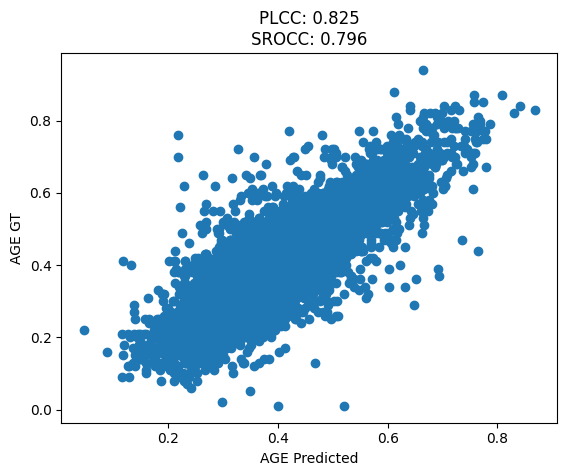

8, [33, 337] loss: 0.0353	PLCC: 0.922	SROCC: 0.916	lr: 0.000202
8, [66, 337] loss: 0.0373	PLCC: 0.909	SROCC: 0.910	lr: 0.000190
8, [99, 337] loss: 0.0349	PLCC: 0.928	SROCC: 0.921	lr: 0.000178
8, [132, 337] loss: 0.0345	PLCC: 0.933	SROCC: 0.928	lr: 0.000167
8, [165, 337] loss: 0.0345	PLCC: 0.922	SROCC: 0.917	lr: 0.000156
8, [198, 337] loss: 0.0345	PLCC: 0.923	SROCC: 0.915	lr: 0.000145
8, [231, 337] loss: 0.0332	PLCC: 0.933	SROCC: 0.929	lr: 0.000135
8, [264, 337] loss: 0.0340	PLCC: 0.931	SROCC: 0.928	lr: 0.000125
8, [297, 337] loss: 0.0337	PLCC: 0.925	SROCC: 0.916	lr: 0.000116
8, [330, 337] loss: 0.0344	PLCC: 0.925	SROCC: 0.919	lr: 0.000106
Validation loss: 0.053095	PLCC: 0.828	SROCC: 0.801


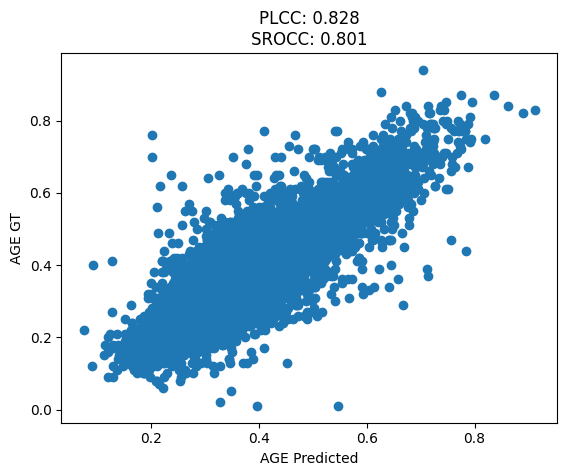

9, [33, 337] loss: 0.0306	PLCC: 0.945	SROCC: 0.938	lr: 0.000096
9, [66, 337] loss: 0.0303	PLCC: 0.946	SROCC: 0.941	lr: 0.000087
9, [99, 337] loss: 0.0306	PLCC: 0.935	SROCC: 0.934	lr: 0.000079
9, [132, 337] loss: 0.0306	PLCC: 0.942	SROCC: 0.935	lr: 0.000072
9, [165, 337] loss: 0.0293	PLCC: 0.943	SROCC: 0.939	lr: 0.000065
9, [198, 337] loss: 0.0310	PLCC: 0.937	SROCC: 0.934	lr: 0.000058
9, [231, 337] loss: 0.0330	PLCC: 0.924	SROCC: 0.918	lr: 0.000052
9, [264, 337] loss: 0.0308	PLCC: 0.937	SROCC: 0.930	lr: 0.000046
9, [297, 337] loss: 0.0317	PLCC: 0.939	SROCC: 0.935	lr: 0.000040
9, [330, 337] loss: 0.0301	PLCC: 0.939	SROCC: 0.939	lr: 0.000035
Validation loss: 0.052773	PLCC: 0.829	SROCC: 0.801


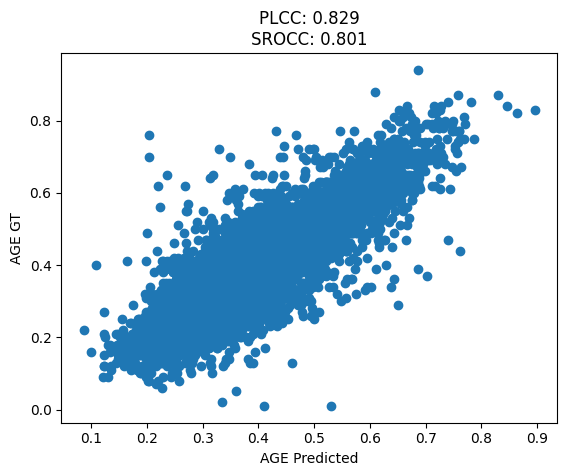

10, [33, 337] loss: 0.0288	PLCC: 0.949	SROCC: 0.948	lr: 0.000030
10, [66, 337] loss: 0.0286	PLCC: 0.945	SROCC: 0.939	lr: 0.000026
10, [99, 337] loss: 0.0283	PLCC: 0.950	SROCC: 0.949	lr: 0.000022
10, [132, 337] loss: 0.0277	PLCC: 0.948	SROCC: 0.944	lr: 0.000019
10, [165, 337] loss: 0.0289	PLCC: 0.938	SROCC: 0.936	lr: 0.000016
10, [198, 337] loss: 0.0285	PLCC: 0.945	SROCC: 0.943	lr: 0.000014
10, [231, 337] loss: 0.0276	PLCC: 0.950	SROCC: 0.943	lr: 0.000012
10, [264, 337] loss: 0.0284	PLCC: 0.950	SROCC: 0.947	lr: 0.000011
10, [297, 337] loss: 0.0284	PLCC: 0.946	SROCC: 0.940	lr: 0.000010
10, [330, 337] loss: 0.0286	PLCC: 0.945	SROCC: 0.941	lr: 0.000010
Validation loss: 0.052542	PLCC: 0.830	SROCC: 0.802


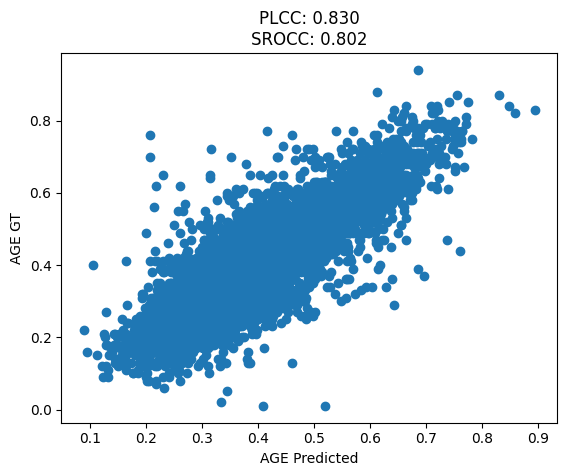

Finished Training


In [ ]:

# Training loop
for epoch in range(epochs):  # Loop over the dataset for multiple epochs
    running_loss = []  # List to store training loss for each batch
    gt_labels = []  # List to store ground truth labels (predicted age)
    pr_labels = []  # List to store predicted labels (model output)

    net.train()  # Set the model to training mode (enables dropout and other training-specific behaviors)

    for i, data in enumerate(trainloader):
        # Get inputs and labels from the data loader
        inputs, labels = data["image"], data["age"]
        gt_labels.append(labels.cpu().numpy())   # Append ground truth

        inputs = inputs.to(device)  # Move data to the appropriate device (CPU or GPU)
        labels = labels.to(device)  # Move labels to the appropriate device

        # Zero the parameter gradients before each backward pass
        optimizer.zero_grad()

        # Forward pass, calculate loss
        outputs = net(inputs)  # Get model predictions

        loss = criterion(outputs.squeeze(), labels)  # Calculate L1 loss between predictions and true labels
        pr_labels.append(outputs.squeeze().detach().cpu())  # Store predictions (detach to avoid gradients)

        # Backward pass and parameter update
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update model weights based on gradients
        scheduler.step()  # Update learning rate according to the scheduler

        # Print statistics (every 10% of the training data)
        running_loss.append(loss.item())
        if (i + 1) % (len(trainloader) // 10) == 0:  # Every 10% of the epoch
            gt_labels = np.stack(list(itertools.chain.from_iterable(gt_labels))).squeeze()  # Combine ground truth labels
            pr_labels = np.stack(list(itertools.chain.from_iterable(pr_labels))).squeeze()  # Combine predictions

            # Calculate and print performance metrics (PLCC, SROCC, learning rate)
            s = spearmanr(gt_labels, pr_labels)[0]  # Spearman Rank Correlation Coefficient
            p = pearsonr(gt_labels, pr_labels)[0]  # Pearson Correlation Coefficient
            print('%d, [%d, %d] loss: %.4f\tPLCC: %.3f\tSROCC: %.3f\tlr: %.6f' %
                  (epoch + 1, i + 1, len(trainloader), np.mean(running_loss), p, s, optimizer.param_groups[-1]['lr']))

            # Clear lists for next iteration within the epoch
            gt_labels = []
            pr_labels = []
            running_loss = []

    # Validation loop (after each training epoch)
    running_loss = []  # List to store validation loss for each batch
    gt_labels = []  # List to store ground truth labels (predicted age)
    pr_labels = []  # List to store predicted labels (model output)

    net.eval()  # Set the model to evaluation mode (deactivates dropout and other training behaviors)

    for i, data in enumerate(valloader):
        # Get inputs and labels from the data loader
        inputs, labels = data["image"], data["age"]
        gt_labels.append(labels.item())  # Append ground truth as single values

        inputs = inputs.to(device)  # Move data to the appropriate device
        labels = labels.to(device)  # Move labels to the appropriate device

        # Forward pass with gradient suppression
        with torch.no_grad():
            outputs = net(inputs)  # Get model predictions without calculating gradients

        pr_labels.append(outputs.squeeze().item())  # Append predictions as single values
        loss = criterion(outputs.squeeze(), labels.squeeze())  # Calculate L1 loss
        running_loss.append(loss.item())

    # Calculate and print validation performance metrics
    gt_labels = np.stack(gt_labels)  # Combine ground truth labels
    pr_labels = np.stack(pr_labels)  # Combine predictions
    s = spearmanr(gt_labels, pr_labels)[0]  # Spearman Rank Correlation Coefficient
    p = pearsonr(gt_labels, pr_labels)[0]  # Pearson Correlation Coefficient
    print('Validation loss: %.6f\tPLCC: %.3f\tSROCC: %.3f' % (np.mean(running_loss), p, s))

    # Visualization (optional)
    plt.scatter(pr_labels, gt_labels)
    plt.xlabel("AGE Predicted")
    plt.ylabel("AGE GT")
    plt.title("PLCC: %.3f\nSROCC: %.3f" % (p, s))
    plt.show()

    # Save the model (optional)
    if epoch == 9:
        torch.save(net.state_dict(), f"models/{net_name}_fc_layer_4_unfrozen_epoch_{epoch}.pth")  # Save model state after each epoch

print('Finished Training')


Evaluate on the test-set

Test loss: 0.052640	PLCC: 0.838	SROCC: 0.813


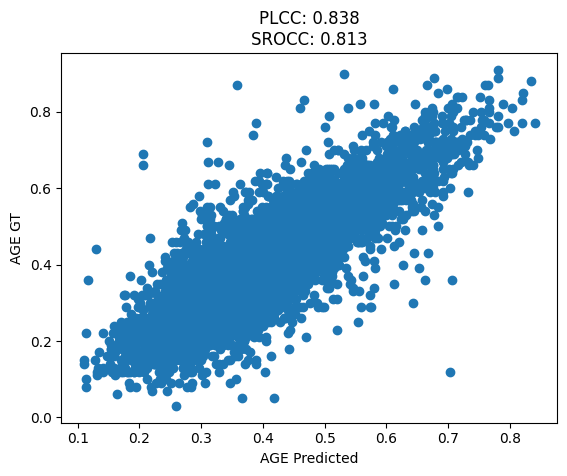

In [ ]:
# Testing loop (after training)
running_loss = []  # List to store test loss for each batch
gt_labels = []  # List to store ground truth labels (predicted age)
pr_labels = []  # List to store predicted labels (model output)

# net = torchvision.models.mobilenet_v2(weights='IMAGENET1K_V1')  # Load pre-trained weights
# num_ftrs = net.classifier[1].in_features  # Get the number of input features for the last layer
# net.classifier = nn.Sequential(
#     nn.Linear(num_ftrs, 512),  # First linear layer with 512 units
#     nn.ReLU(),  # GELU activation function
#     nn.Linear(512, 32),  # Second linear layer with 32 units
#     nn.GELU(),  # GELU activation function
#     nn.Linear(32, 1)   # Output layer with 1 unit (for age prediction)
# )

# # Load the checkpoint
# net.load_state_dict(torch.load('models/MobileNetV2_only_fc_unfrozen_epoch_9.pth'))

# print(net.__class__.__name__)
# net.to(device)

net.eval()  # Set the model to evaluation mode (deactivates dropout and other training behaviors)

for i, data in enumerate(testloader):
    # Get inputs and labels from the data loader
    inputs, labels = data["image"], data["age"]
    gt_labels.append(labels.item())  # Append ground truth as single values

    inputs = inputs.to(device)  # Move data to the appropriate device
    labels = labels.to(device)  # Move labels to the appropriate device

    # Forward pass with gradient suppression
    with torch.no_grad():
        outputs = net(inputs)  # Get model predictions without calculating gradients

    pr_labels.append(outputs.squeeze().item())  # Append predictions as single values
    loss = criterion(outputs.squeeze(), labels.squeeze())  # Calculate L1 loss
    running_loss.append(loss.item())

# Calculate and print test performance metrics
gt_labels = np.stack(gt_labels)  # Combine ground truth labels
pr_labels = np.stack(pr_labels)  # Combine predictions
s = spearmanr(gt_labels, pr_labels)[0]  # Spearman Rank Correlation Coefficient
p = pearsonr(gt_labels, pr_labels)[0]  # Pearson Correlation Coefficient
print('Test loss: %.6f\tPLCC: %.3f\tSROCC: %.3f' % (np.mean(running_loss), p, s))

# Visualization (optional)
plt.scatter(pr_labels, gt_labels)
plt.xlabel("AGE Predicted")
plt.ylabel("AGE GT")
plt.title("PLCC: %.3f\nSROCC: %.3f" % (p, s))
plt.show()

**!ASSIGNMENT!**

*Transfer learning*
1. Finetune all the layers of the current network (mobilenet_v2).
2. Swap out the current model with a new one from [here](https://pytorch.org/vision/main/models.html#classification) that is already trained on Imagenet. Then, fine-tune the network and compare how well it performs on the test-set compared to the current network (mobilenet_v2) using PLCC and SROCC metrics.